# Tweet Sentiment Analysis

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# set a random seed for reproducibility
seed = 3490

## Load Data

In [2]:
encodings = ["utf-8-sig", "cp1252", "iso-8859-1", "latin1"]
for encoding in encodings:
    try:
        data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding=encoding)
    except:
        continue
print(encoding)
data.head()

latin1


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Explore Data

In [40]:
print(f'How much data do we have?\n{data.shape[0]} records.')
print('\n')
print(f'Example of a tweet in the dataset:\n"{data.tweet_text[0]}"')
print('\n')
print(f'Which products are the tweets concerning?\n{list(data.emotion_in_tweet_is_directed_at.value_counts().index)}')
print('\n')
class_distribution = data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)
print(f'Is this an imbalanced classification problem?\n{class_distribution}')

How much data do we have?
9093 records.


Example of a tweet in the dataset:
".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW."


Which products are the tweets concerning?
['iPad', 'Apple', 'iPad or iPhone App', 'Google', 'iPhone', 'Other Google product or service', 'Android App', 'Android', 'Other Apple product or service']


Is this an imbalanced classification problem?
No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64


If we start by building a classifier which classifies tweets as containing positive or negative emotions, then we can only use 38% of the available data. For that reason, I want to build a multi-class classifier from the beginning.

## Prepare Data for Modeling

**Handle Missing Data**

Check for missing data.

In [12]:
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

For now, we will ignore towards which product the sentiment in the tweet is directed, which allows us to ignore the missing data in the "emotion_in_tweet_is_directed_at" column.

View the record which is missing "tweet_text" data.

In [15]:
data.loc[data.tweet_text == None]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


We can safely drop this record.

In [3]:
clean_data = data.dropna(subset=['tweet_text'])

**Drop Data for Which Sentiment Category is "I can't tell"**

In [4]:
clean_data = clean_data.loc[clean_data.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]

**Drop Column Specifying At Which Product the Sentiment is Directed**

In [5]:
clean_data = clean_data.drop(columns='emotion_in_tweet_is_directed_at')

**Rename Sentiment Column**

In [6]:
clean_data = clean_data.rename({'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1)

**Inspect First Few Rows of Cleaned Data:**

In [7]:
clean_data.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [8]:
clean_data.shape

(8936, 2)

## Load Pre-trained GloVe Vectors

Load pre-trained word vectors (to give more context to our 9000 or so tweets.)

In [10]:
with open('data/glove.twitter.27B.50d.txt') as f:
    lines = f.readlines()

In [11]:
glove = dict()

for line in lines:
    items = line.split()
    word = items[0]
    vector = items[1:]
    glove[word] = [float(component) for component in vector]

Save to file, so we don't have to run the above code every time we restart the kernel.

In [13]:
import json
with open("data/glove.txt", "w") as filepath:
    json.dump(glove, filepath) 

**Load preprocessed glove dictionary here:**

In [9]:
import json
with open("data/glove.txt", "r") as file:
    glove = json.load(file)

In [10]:
len(glove.keys())

1193514

We have 1,193,514 words and characters which have been vectorized for us (in the context of Twitter.)

## Train Test Split

The next step is to split our data into training and testing sets, and then preprocess the tweet text for our classifier using our glove vectors.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_data['tweet_text'],
                                                    clean_data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=seed)

X_train.head(2)

8841    Next #SXSW we're heading to is about designing...
1099    Talked to some great developers at the Android...
Name: tweet_text, dtype: object

## Vectorize Tweets for Modeling

Define a function to go through the text of each tweet and get the (GloVe) vector representation for each word, then mind the mean word vector for the entire tweet.

In [55]:
import string

def get_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(glove[token.lower().strip(string.punctuation)])
        except:
#             print(token)     we're losing quite a few tokens, but will ignore for now
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

Note that this function does not pad each tweet. I am curious to see the effect of padding versus not padding on the classifier.

In [57]:
X_train_preprocessed = X_train.apply(get_mean_word_vector)

In [58]:
X_test_preprocessed = X_test.apply(get_mean_word_vector)

The series above are not in the correct format for a scikit learn classifier. To convert to a matrix of features, use the below loop:

In [59]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed.values]
    preprocessed_values[label] = values

final_X_train = pd.DataFrame(preprocessed_values, index=X_train.index)

In [60]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_test_preprocessed.values]
    preprocessed_values[label] = values

final_X_test = pd.DataFrame(preprocessed_values, index=X_test.index)

## Label Encode Target

Label encode the target.

In [61]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_preprocessed = le.fit_transform(y_train)
y_test_preprocessed = le.transform(y_test)

print(le.classes_)

['Negative emotion' 'No emotion toward brand or product'
 'Positive emotion']


## Store Modeling Results

To keep up with the performance of different models, build a dictionary for scores.

In [62]:
model_eval = {'name': [], 'model': [], 'accuracy': []}

from sklearn.base import clone # to store models

## Build Baseline Classifier

Options for classifier:

- logistic regression
- decision tree
- k nearest neighbors
- random forest
- boosted random forest

Our baseline classifier will be a logistic regression.

In [63]:
from sklearn.linear_model import LogisticRegression

For logistic regression, the data needs to be scaled.

In [64]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_test = ss.transform(final_X_test)

Perform cross validation on the scaled training data.

In [65]:
from sklearn.model_selection import cross_val_score

In [66]:
baseline = LogisticRegression(random_state=seed)

cross_val_score(baseline, scaled_X_train, y_train_preprocessed)

array([0.64615385, 0.63706294, 0.63916084, 0.6550035 , 0.64660602])

Store the results.

In [67]:
model_eval['name'].append('baseline')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(np.mean(cross_val_score(baseline, scaled_X_train, y_train_preprocessed)))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797


Explore the results a little more. Examine where the model is making correct predictions and where it is making incorrect predictions.

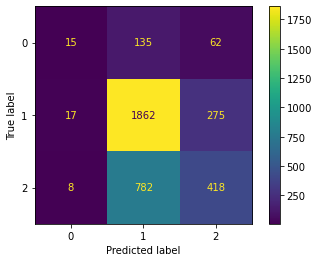

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=2, shuffle=True, random_state=seed)

for train, test in kfolds.split(scaled_X_train, y_train_preprocessed):
    train_split = train
    test_split = test
    break
    
baseline.fit(scaled_X_train[train_split], y_train_preprocessed[train_split])
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split])
                                       )).plot();

In [58]:
print(f'The model is predicting the majority class "{le.classes_[1]}" quite well.')
print(f'The model is classifying a large proportion of the other two classes as the majority class.')

The model is predicting the majority class "No emotion toward brand or product" quite well.
The model is classifying a large proportion of the other two classes as the majority class.


Here is the percentage of each true class which is correctly labeled. The model's recall for each class is on the diagonal.

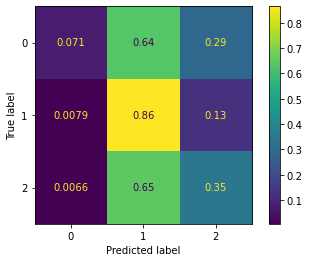

In [69]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='true'
                                       )).plot();

Here is the percentage of the model's predictions for each class which are correct. The model's precision for each class is on the diagonal.

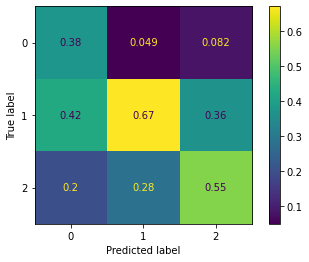

In [70]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='pred'
                                       )).plot();

In [71]:
le.classes_[0]

'Negative emotion'

In [72]:
cf = confusion_matrix(y_train_preprocessed[test_split], baseline.predict(scaled_X_train[test_split]))

print('Recall of Negative Emotion Tweets:')
print(cf[0][0] / np.sum([cf[0][i] for i in range(3)]))

Recall of Negative Emotion Tweets:
0.07075471698113207


## Evaluation Metrics

Looking at the accuracy for each class is a reasonable measure of the model's performance.

It is also important to look at the **recall for negative tweets** in particular because we want to respond quickly to negative feedback to improve customer satisfaction and brand perception.

Right now, our model has a recall for negative tweets specifically of only 7%.

## Increase Recall of Negative Tweets

One strategy for increasing the model's recall of negative tweets is to change the threshold for predicting that a tweet is negative.

Currently, our model selects the category with the highest probability.

For example, if the predicted probabilities for negative, neutral and positive are $.33$, $.36$ and $.31$, then the model will predict that the tweet is neutral. But if the model has even a 30% confidence that the tweet is negative, we may want to classify that tweet as negative.

We can set some custom thresholds as follows:

- If the model is 30% confident (or more) that a tweet is negative, and less than 50% confident that the tweet is neutral or positive, then classify the tweet as negative.

- Otherwise, classify the tweet according to highest confidence level.

In [73]:
import random

thresholded_preds = []

for probs in baseline.predict_proba(scaled_X_train[test_split]):
    if probs[0] >= 0.3:
        if (probs[1] <= 0.5) and (probs[2] <= 0.5):
            thresholded_preds.append(0)
        elif probs[1] > 0.5:
            thresholded_preds.append(1)
        else:
            thresholded_preds.append(2)
    else:
        if probs[1] > probs[2]:
            thresholded_preds.append(1)
        elif probs[1] < probs[2]:
            thresholded_preds.append(2)
        else:
            thresholded_preds.append(random.randint(1,2))

Check recall of thresholded predictions.

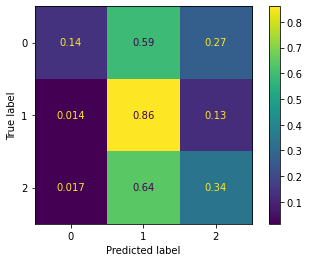

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        thresholded_preds,
                                        normalize='true'
                                       )).plot();

Applying some custom thresholding increased the recall of negative tweets from 7% to 14%.

Make the above thresholding code into a function to apply repeatedly in search of the best thresholding schema.

In [75]:
import random

def custom_threshold_predict(model, X, neg_threshold, pos_threshold, neut_threshold):
    
    thresholded_preds = []

    for probs in model.predict_proba(X):
        # negative tweet confidence above threshold
        if probs[0] >= neg_threshold:
            # positive and neutral confidence below thresholds
            if (probs[1] <= neut_threshold) and (probs[2] <= pos_threshold):
                thresholded_preds.append(0)
            # positive and neutral confidence both above thresholds
            elif (probs[1] > neut_threshold) and (probs[2] > pos_threshold):
                # select class with highest probability, or choose randomly if equal
                if probs[1] > probs[2]:
                    thresholded_preds.append(1)
                elif probs[1] < probs[2]:
                    thresholded_preds.append(2)
                else:
                    thresholded_preds.append(random.randint(1,2))
            # positive or netural confidence is above, the other is below, their thresholds 
            elif (probs[1] > neut_threshold) and (probs[2] < pos_threshold):
                thresholded_preds.append(1)
            elif (probs[1] < neut_threshold) and (probs[2] > pos_threshold):
                thresholded_preds.append(2)
            # if all three classes are outside of their thresholds, pick class with highest probability
            else:
                thresholded_preds.append(np.argmax(probs))
        # if negative tweet confidence is NOT above threshold, pick highest probability
        else:
            thresholded_preds.append(np.argmax(probs))

Store results.

In [76]:
from sklearn.metrics import accuracy_score

model_eval['name'].append('thresholded_baseline')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(accuracy_score(y_train_preprocessed[test_split], thresholded_preds))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578


Now, let's tune the classification algorithm itself, then threshold the best classifier found.

## Test Padding Mean Word Vector for Different Length Tweets

In [77]:
X_train.map(lambda x: len(x.split())).describe()

count    7148.000000
mean       17.758254
std         4.954223
min         2.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        32.000000
Name: tweet_text, dtype: float64

Based on the above descriptive statistics for the length (in words) of each tweet, 21 would be a good "length" for the mean tweet vector.

\*Note: the mean tweet vector has a dimensionality of 50, but I am going to try considering a list of word vectors of length 21, regardless of whether a tweet has fewer or greater than 21 words in it.

In [78]:
test_array = [[1, 2, 5], [3, 4, 7]]
test_array.append([0]*3)
np.array(test_array)

array([[1, 2, 5],
       [3, 4, 7],
       [0, 0, 0]])

In [79]:
import string

def get_mean_word_vector2(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(glove[token.lower().strip(string.punctuation)])
        except:
#             print(token)     we're losing quite a few tokens, but will ignore for now
            continue
    # pad with 0 vectors if less than 21 words in length
    while len(tweet_vectors) < 21:
        tweet_vectors.append([0]*50)
    # save first 21 word vectors as an array
    padded_tweet_vector = np.array(tweet_vectors[:21])
    # return the mean of these 21 word vectors
    return np.mean(padded_tweet_vector, axis=0)

In [80]:
X_train_preprocessed2 = X_train.apply(get_mean_word_vector2)

X_test_preprocessed2 = X_test.apply(get_mean_word_vector2)

In [81]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed.values]
    preprocessed_values[label] = values

final_X_train2 = pd.DataFrame(preprocessed_values, index=X_train.index)

preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_test_preprocessed.values]
    preprocessed_values[label] = values

final_X_test2 = pd.DataFrame(preprocessed_values, index=X_test.index)

In [82]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train2 = ss.fit_transform(final_X_train2)
scaled_X_test2 = ss.transform(final_X_test2)

In [83]:
cross_val_score(baseline, scaled_X_train2, y_train_preprocessed)

array([0.64615385, 0.63706294, 0.63916084, 0.6550035 , 0.64660602])

In [84]:
model_eval['name'].append('baseline_w_padded_mean_word_vector')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(np.mean(cross_val_score(baseline, scaled_X_train2, y_train_preprocessed)))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797


There is practically no difference, so I will continue without padding.

## Tuning Logistic Regression

In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C': [0.001, 0.1, 1, 1000],
     'class_weight': [None, 'balanced'],
     'random_state': [seed],
     'max_iter': [1000]},
    {'penalty': ['elasticnet'],
     'solver': ['saga'],
     'l1_ratio': [0.25, 0.5, 0.75],
     'C': [0.001, 0.1, 1, 1000],
     'max_iter': [1000]},
    {'penalty': ['l1'],
     'solver': ['saga'],
     'C': [0.001, 0.1, 1, 1000],
     'random_state': [seed],
     'max_iter': [1000]}
]

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, scoring='accuracy')

grid_search.fit(scaled_X_train, y_train_preprocessed)

print(grid_search.best_score_)

0.6452173019422844


In [87]:
model_eval['name'].append('tuned_logreg')
model_eval['model'].append(clone(grid_search.best_estimator_))
model_eval['accuracy'].append(grid_search.best_score_)
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797
3,tuned_logreg,"LogisticRegression(C=1, l1_ratio=0.75, max_ite...",0.645217


## Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)

cross_val_score(rf, scaled_X_train, y_train_preprocessed)

array([0.64755245, 0.63916084, 0.65454545, 0.66689993, 0.65640308])

In [89]:
model_eval['name'].append('baseline_random_forest')
model_eval['model'].append(clone(rf))
model_eval['accuracy'].append(np.mean(cross_val_score(rf, scaled_X_train, y_train_preprocessed)))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797
3,tuned_logreg,"LogisticRegression(C=1, l1_ratio=0.75, max_ite...",0.645217
4,baseline_random_forest,RandomForestClassifier(random_state=3490),0.652912


**Make a function to record model results:**

In [101]:
def log_model_results(name, model, x_data=scaled_X_train, y_data=y_train_preprocessed):
    '''Pass in a name and a model; store model's name, a clone of model & accuracy.'''
    global model_eval

    model_eval['name'].append(name)
    model_eval['model'].append(clone(model))
    model_score = np.mean(cross_val_score(model, x_data, y_data))
    model_eval['accuracy'].append(model_score)
    
    return pd.DataFrame(model_eval)

## Build Custom word2Vec Embeddings 2

In [92]:
import gensim

In [93]:
corpus = []
for tweet in X_train.values:
    corpus.append(gensim.utils.simple_preprocess(tweet))

In [94]:
custom_embeddings = gensim.models.Word2Vec(corpus,
                                           size=50,
                                           window=5,
                                           iter=10)

In [95]:
import string

def get_custom_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(custom_embeddings.wv[token.lower().strip(string.punctuation)])
        except:
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

In [96]:
X_train_preprocessed3 = X_train.apply(get_custom_mean_word_vector)

In [97]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed3.values]
    preprocessed_values[label] = values

final_X_train3 = pd.DataFrame(preprocessed_values, index=X_train.index)

In [98]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train3 = ss.fit_transform(final_X_train3)

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression(random_state=seed, max_iter=10000)

cross_val_score(baseline, scaled_X_train3, y_train_preprocessed)

array([0.60769231, 0.62447552, 0.61608392, 0.63261022, 0.62141358])

In [102]:
log_model_results('custom_embeddings', baseline, scaled_X_train3, y_train_preprocessed)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797
3,tuned_logreg,"LogisticRegression(C=1, l1_ratio=0.75, max_ite...",0.645217
4,baseline_random_forest,RandomForestClassifier(random_state=3490),0.652912
5,custom_embeddings,"LogisticRegression(max_iter=10000, random_stat...",0.620455


## Tuning Random Forest

In [103]:
balanced_rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

In [104]:
log_model_results('balanced_rf', balanced_rf)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797
3,tuned_logreg,"LogisticRegression(C=1, l1_ratio=0.75, max_ite...",0.645217
4,baseline_random_forest,RandomForestClassifier(random_state=3490),0.652912
5,custom_embeddings,"LogisticRegression(max_iter=10000, random_stat...",0.620455
6,balanced_rf,RandomForestClassifier(class_weight='balanced'...,0.650813


In [105]:
balanced_rf.fit(scaled_X_train, y_train_preprocessed)

RandomForestClassifier(class_weight='balanced', random_state=3490)

In [115]:
estimator_depths = [estimator.get_depth() for estimator in balanced_rf.estimators_]
print(f'Mean depth: {np.mean(estimator_depths)}')
print(f'Standard deviation: {np.std(estimator_depths)}')

Mean depth: 30.68
Standard deviation: 4.27990654103568


In [119]:
param_grid = [
    {'random_state': [seed],
     'max_depth': [5, 10, 20, 30],
     'class_weight': [None, 'balanced']}
]

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy')

grid_search.fit(scaled_X_train, y_train_preprocessed)

GridSearchCV(estimator=RandomForestClassifier(random_state=3490),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'max_depth': [5, 10, 20, 30],
                          'random_state': [3490]}],
             scoring='accuracy')

In [120]:
grid_search.best_score_

0.6555677352738234

In [121]:
log_model_results('tuned_rf', grid_search.best_estimator_)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797
3,tuned_logreg,"LogisticRegression(C=1, l1_ratio=0.75, max_ite...",0.645217
4,baseline_random_forest,RandomForestClassifier(random_state=3490),0.652912
5,custom_embeddings,"LogisticRegression(max_iter=10000, random_stat...",0.620455
6,balanced_rf,RandomForestClassifier(class_weight='balanced'...,0.650813
7,tuned_rf,"RandomForestClassifier(max_depth=20, random_st...",0.655568


## Binary Classifier

In [122]:
clean_data.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [123]:
clean_data.sentiment.value_counts(normalize=True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: sentiment, dtype: float64

In [124]:
binary_data = clean_data.loc[clean_data.sentiment != 'No emotion toward brand or product']

In [125]:
binary_data.sentiment.value_counts(normalize=True)

Positive emotion    0.839346
Negative emotion    0.160654
Name: sentiment, dtype: float64

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(binary_data['tweet_text'],
                                                    binary_data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=seed)

In [134]:
y_train.value_counts(normalize=True)

Positive emotion    0.842142
Negative emotion    0.157858
Name: sentiment, dtype: float64

In [135]:
y_test.value_counts(normalize=True)

Positive emotion    0.828169
Negative emotion    0.171831
Name: sentiment, dtype: float64

### Preprocessing with GloVe

In [140]:
# GloVe word2vec vectorization
preprocessed_train_values = dict()
preprocessed_test_values = dict()

for i in range(50):
    label = f'feature_{i}'
    # get i^th component of each mean tweet vector
    train_values = [vector[i] for vector in X_train.apply(get_mean_word_vector)]
    test_values = [vector[i] for vector in X_test.apply(get_mean_word_vector)]
    # store
    preprocessed_train_values[label] = train_values
    preprocessed_test_values[label] = test_values

final_X_train = pd.DataFrame(preprocessed_train_values, index=X_train.index)
final_X_test = pd.DataFrame(preprocessed_test_values, index=X_test.index)

In [145]:
# scale
scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_test = ss.transform(final_X_test)

In [149]:
# label encode target
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_preprocessed = le.fit_transform(y_train)
y_test_preprocessed = le.transform(y_test)

print(le.classes_)

['Negative emotion' 'Positive emotion']


In [151]:
# score baseline
baseline = LogisticRegression(random_state=seed)

np.mean(cross_val_score(baseline, scaled_X_train, y_train_preprocessed))

0.8442488262910798

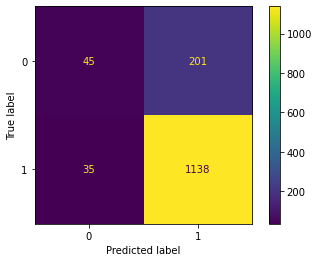

In [153]:
# examine positive / negative breakdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=2, shuffle=True, random_state=seed)

for train, test in kfolds.split(scaled_X_train, y_train_preprocessed):
    train_split = train
    test_split = test
    break
    
baseline.fit(scaled_X_train[train_split], y_train_preprocessed[train_split])
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split])
                                       )).plot();

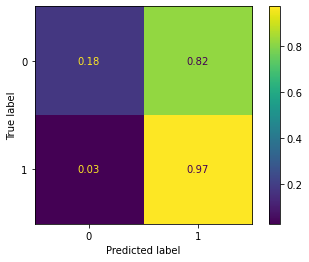

In [155]:
# Check recall of negative tweets
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='true'
                                       )).plot();

18% of negative tweets are being captured.

In [164]:
# undersample
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed)

X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                              y_train_preprocessed)

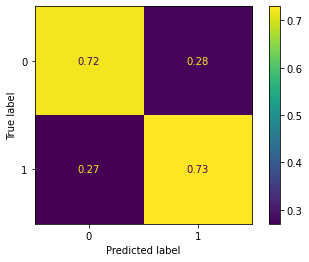

In [167]:
# refit
baseline.fit(X_train_undersampled, y_train_undersampled)

# Check recall of negative tweets
ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(scaled_X_test),
                                        normalize='true'
                                       )).plot();

In [169]:
np.mean(cross_val_score(baseline, X_train_undersampled, y_train_undersampled))

0.6997951582867783

Undersampling drastically decreases the overall accuracy of the model, but drastically increases the recall of negative tweets.

In [172]:
recall_of_neg_tweets = []
overall_accuracy = []

for ratio in np.linspace(0.5, 1, 6):
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=ratio)
    
    X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                                  y_train_preprocessed)
    
    baseline.fit(X_train_undersampled, y_train_undersampled)

    overall_accuracy.append(accuracy_score(y_test_preprocessed,
                                           baseline.predict(scaled_X_test)))
    neg_recall = confusion_matrix(y_test_preprocessed, baseline.predict(scaled_X_test),
                                  normalize='true')[0][0]
    recall_of_neg_tweets.append(neg_recall)

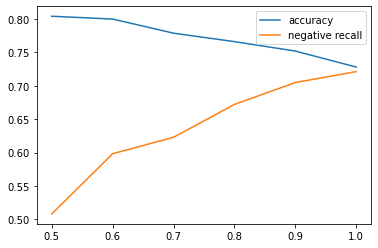

In [176]:
fig, ax = plt.subplots()

plt.plot(np.linspace(0.5, 1, 6), overall_accuracy, label='accuracy')
plt.plot(np.linspace(0.5, 1, 6), recall_of_neg_tweets, label='negative recall')

ax.legend();

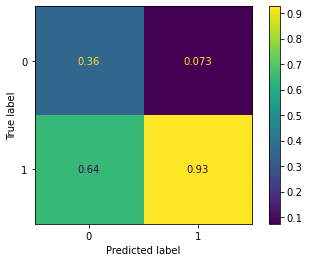

In [178]:
# Check precision of positive/negative tweets

rus = RandomUnderSampler(random_state=seed)

X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                              y_train_preprocessed)

baseline.fit(X_train_undersampled, y_train_undersampled)

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(scaled_X_test),
                                        normalize='pred'
                                       )).plot();

With undersampling, our model has 36% precision in negative tweets, and 93% precision in positive tweets. (It is only right 36% of the time when predicting that a tweet is negative!)

### Preprocessing as a Bag of Words

In [199]:
from nltk.tokenize import word_tokenize
import string

def custom_tokenize(tweet):
    list_of_words = tweet.split()
    clean_list = [word.strip(string.punctuation).lower() for word in list_of_words]
    clean_tweet = ' '.join(clean_list)
    return word_tokenize(clean_tweet)

In [200]:
test_tweet = "@samantha here is a test tweet!! to make sure This works."

In [201]:
custom_tokenize(test_tweet)

['samantha',
 'here',
 'is',
 'a',
 'test',
 'tweet',
 'to',
 'make',
 'sure',
 'this',
 'works']

In [203]:
X_train.apply(custom_tokenize)

8487    [well, austin, 's, the, only, place, in, the, ...
7153    [hooray, more, long, lines, rt, mention, apple...
8428    [mention, the, constant, ipad, to, iphone, swi...
1907    [best, schwag, i, 've, seen, at, sxsw, is, the...
3410    [to, be, enchanting, offer, the, likeability, ...
                              ...                        
4452    [rt, @, mention, t, 's, not, a, rumor, apple, ...
498     [i, need, to, find, a, better, sxsw, stream, t...
6676    [rt, mention, soundtrckr, featured, by, mentio...
1858    [learning, about, all, the, latest, food, rela...
8241    [if, i, do, n't, have, my, iphone, back, by, s...
Name: tweet_text, Length: 2838, dtype: object

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=0.05)

tfidf_X_train = pd.DataFrame(
    tfidf.fit_transform(X_train.apply(lambda x: ' '.join(custom_tokenize(x)))).todense(),
    columns=list(tfidf.vocabulary_.keys()),
    index=X_train.index)

In [236]:
tfidf_X_test = pd.DataFrame(
    tfidf.transform(X_test.apply(lambda x: ' '.join(custom_tokenize(x)))).todense(),
    columns=list(tfidf.vocabulary_.keys()),
    index=X_test.index)

In [229]:
np.mean(
cross_val_score(baseline, tfidf_X_train, y_train_preprocessed)
)

0.8446108751273069

In [231]:
train_split

array([   0,    2,    7, ..., 2828, 2830, 2832])

In [233]:
tfidf_X_train.head()

,austin,the,in,to,get,an,ipad,an ipad,rt,mention,...,out,app,on,by,at the,apple store,they,pop,pop up,not
8487,0.000000,0.356074,0.417936,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.414441,0.000000,0.0,0.0,0.234032,0.0,0.0,0.0
7153,0.331530,0.000000,0.000000,0.0,0.0,0.0,0.203186,0.0,0.0,0.000000,...,0.0,0.0,0.166092,0.349149,0.0,0.0,0.000000,0.0,0.0,0.0
8428,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.347047,...,0.0,0.0,0.296008,0.000000,0.0,0.0,0.334308,0.0,0.0,0.0
1907,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.304195,...,0.0,0.0,0.259459,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3410,0.322804,0.000000,0.000000,0.0,0.0,0.0,0.197838,0.0,0.0,0.000000,...,0.0,0.0,0.323441,0.000000,0.0,0.0,0.182645,0.0,0.0,0.0


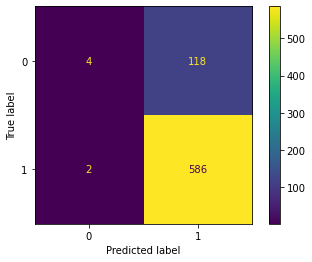

In [237]:
baseline.fit(tfidf_X_train, y_train_preprocessed)

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(tfidf_X_test)
                                       )).plot();

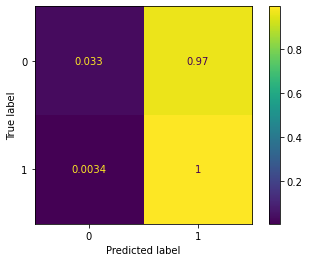

In [239]:

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(tfidf_X_test),
                                        normalize='true'
                                       )).plot();

Using a simple bag of words representation with term frequency inverse document frequency vectorization results in the best recall of positive tweets so far, but the worst recall of negative tweets so far.